In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [2]:
import torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

## Read Config file

In [4]:
config_path = "/root/second.pytorch/second/configs/car.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
config_tool.change_detection_range_v2(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [5]:
ckpt_path = "/root/second.pytorch/second/weights/chk1/voxelnet-2320.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

[  41 2000 2000]


## Generate Anchors

In [6]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

## Read KITTI infos
you can load your custom point cloud.

In [7]:
info_path = input_cfg.dataset.kitti_info_path
root_path = Path(input_cfg.dataset.kitti_root_path)
with open(info_path, 'rb') as f:
    infos = pickle.load(f)

## Load Point Cloud, Generate Voxels

In [9]:
info = infos[564]
v_path = info["point_cloud"]['velodyne_path']
v_path = str(root_path / v_path)
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 4])
res = voxel_generator.generate(points, max_voxels=90000)
voxels, coords, num_points = res['voxels'], res['coordinates'], res['num_points_per_voxel']
print(voxels.shape)
# add batch idx to coords
coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
coords = torch.tensor(coords, dtype=torch.int32, device=device)
num_points = torch.tensor(num_points, dtype=torch.int32, device=device)

(84129, 5, 4)


## Detection

In [10]:
example = {
    "anchors": anchors,
    "voxels": voxels,
    "num_points": num_points,
    "coordinates": coords,
}
pred = net(example)[0]

## Simple Vis

In [11]:
boxes_lidar = pred["box3d_lidar"].detach().cpu().numpy()
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)

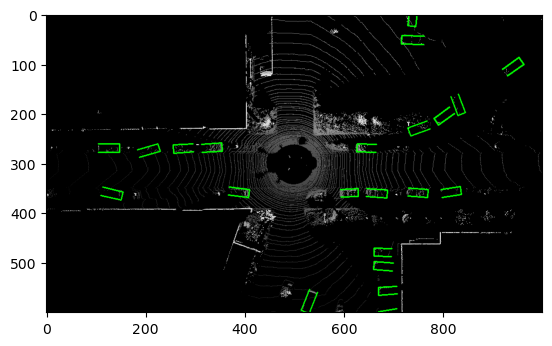

In [12]:
plt.imshow(bev_map)